Los datos de movilidad de población española descargados desde la página web del Ministerio de Transportes de España: https://www.mitma.es/ministerio/covid-19/evolucion-movilidad-big-data/opendata-movilidad. 

Empezamos por explorar los datos para un día seleccionado de la semana de referencia (antes de restricciones impuestas por COVID-19), el viernes de febrero 14 de 2020.

Importamos las librerias de Python que vamos a necesitar.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Los datos están en formato '.txt' con los campos separados con la barra vertical "|".Indicamos la carpeta con el archivo e importamos los datos a una tabla. La opción "low_memory=False" nos deja importar sin indicar tipos de datos en las columnas, Pandas lo va a hacer por nosotros.

In [2]:
path = './febrero/20200214_maestra_1.txt'
file= pd.read_csv(path, sep="|", low_memory=False)

Vamos a ver cuantos registros y cuantas columnas hay en la tabla.

In [3]:
file.count()

fecha                6585132
origen               6585132
destino              6585132
actividad_origen     6585132
actividad_destino    6585132
residencia           6585132
edad                       0
periodo              6585132
distancia            6585132
viajes               6585132
viajes_km            6585132
dtype: int64

La tabla contiene 6,5 millones de registros y 11 columnas, una de ellas ("edad") está vacía por lo cual podemos eliminarla.

In [3]:
file.drop('edad', axis=1, inplace=True)
file.head(5)

,fecha,origen,destino,actividad_origen,actividad_destino,residencia,periodo,distancia,viajes,viajes_km
0,20200214,01001_AM,01001_AM,casa,otros,1,0,002-005,8.203,33.073
1,20200214,01001_AM,01001_AM,casa,otros,1,0,005-010,10.080,62.972
2,20200214,01001_AM,01001_AM,casa,otros,1,1,002-005,15.592,65.630
3,20200214,01001_AM,01001_AM,casa,otros,1,1,005-010,15.184,129.594
4,20200214,01001_AM,01001_AM,casa,otros,1,3,005-010,7.675,48.108


Según el "Informe metodológico" (que hemos descargado de aquí: https://www.mitma.es/ministerio/covid-19/evolucion-movilidad-big-data), las columnas representan la información siguientes:

'fecha' - en formato 'YYYYMMDD'
'origen' - el código del distrito donde el viaje se inició
'destino' - el código del distrito donde el viaje se acabó
'actividad_origen' and 'actividad_destino' - descripción de los puntos iniciales y finales
'residencia' - el código de residencia del viajero
'periodo' - la hora donde el viaje se inició
'distancia' - longitud del viaje
'viajes' - número de viajes para la combinación específica de valores en las columnas precedentes
'viajes_km' - número de kilómetros recorridos por todos viajeres para la combinación específica de valores en las columnas precedentes

Vamos a ver cuantos valores únicos tiene la columna "residencia".

In [4]:
file['residencia'].unique()

array([ 1,  8,  9, 11, 20, 21, 24, 26, 28, 31, 38, 47, 48, 32, 17, 39, 12,
       14, 42, 46, 43,  3, 33, 37, 41, 18,  5, 50, 44, 15,  6, 34, 22, 36,
       10, 23, 30, 13, 40,  4, 45,  7, 35, 29, 49, 25, 27, 19, 16,  2, 52,
       51], dtype=int64)

Por haber 52 unique values concluimos que son los códigos de 50 provincias de España más 2 ciudades autónomas de Ceuta y Melilla.
Y qué está en las columnas "origen" y "destino"? También son los códigos de provincias?

In [5]:
len(file['origen'].unique())

2839

In [6]:
len(file['destino'].unique())

2839

El número de valores únicos en las dos columnas supera de forma significativa el número de provincias. Entonces, son las zonas más pequeñas. Añadimos a la tabla dos columnas para indicar las provincias de procedencia y terminación de viajes.
Aqui definimos la función para sacar el código de provincia desde el código de zona:

In [7]:
def recode (df, column):
    source = np.array(df[column])
    result = []
    for code in source:
        if code[0]=='0':
            result.append(int(code[1:2]))
        else:
            result.append(int(code[0:2]))
    name = 'recoded_' + column
    
    df[name] = result    

La función va a añadir dos columnas nuevas a la tabla:

In [12]:
recode(file,'origen')
recode(file,'destino')
file.head(5)

,fecha,origen,destino,actividad_origen,actividad_destino,residencia,periodo,distancia,viajes,viajes_km,recoded_origen,recoded_destino
0,20200214,01001_AM,01001_AM,casa,otros,1,0,002-005,8.203,33.073,1,1
1,20200214,01001_AM,01001_AM,casa,otros,1,0,005-010,10.080,62.972,1,1
2,20200214,01001_AM,01001_AM,casa,otros,1,1,002-005,15.592,65.630,1,1
3,20200214,01001_AM,01001_AM,casa,otros,1,1,005-010,15.184,129.594,1,1
4,20200214,01001_AM,01001_AM,casa,otros,1,3,005-010,7.675,48.108,1,1


Averiguamos que todos los registros tengan la misma fecha (esperamos a ver el febrero 14).

In [8]:
file.fecha.unique()

array([20200214], dtype=int64)

Antes de empezar el análisis tenemos que escoger la variable que represente el nivel de movilidad. Parece que el campo "viajes_km" puede ser apropiado. 

Para ver el número de kilometros recorridos por todos los viajeros en cada hora y cada provincia, creamos una tabla nueva con datos consolidados.

In [15]:
x=range(24)
df = pd.DataFrame(x)

provincias=list(range(1,53))

for code in provincias:
    
    provincia= file[file['recoded_origen']==code]
    data = provincia[['periodo','viajes_km']]
    grouped = data.groupby(by=["periodo"]).sum()
    y = grouped['viajes_km']
    df[code]=y
    
df.rename(columns={0:'hora'}, inplace=True)

In [16]:
df.head()

,hora,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,0,92803.316,164210.435,518210.882,329358.071,67491.505,216736.134,264824.899,1652882.141,142703.320,...,259607.705,41703.229,274482.187,766377.674,179982.816,229147.398,136410.926,422059.783,14128.802,37091.411
1,1,86847.687,81538.927,393489.830,203897.826,58026.406,192703.795,197998.273,1211816.240,144745.356,...,193971.642,37632.473,263551.598,719767.137,150022.647,173534.203,131087.586,465283.087,9077.673,18350.406
2,2,58407.743,69838.805,374452.610,161152.235,41392.384,206187.100,193373.220,1340067.594,114633.884,...,224915.211,34094.801,272050.210,726659.749,156607.051,177868.575,142872.481,429346.311,6487.513,25293.079
3,3,93307.185,140822.417,488560.248,326009.173,64028.268,219616.018,270823.160,1606906.907,116888.663,...,284854.622,58943.495,382766.763,946706.396,192281.659,231860.598,122176.265,530496.113,5000.881,10022.315
4,4,191336.785,184585.324,689755.851,243265.004,71811.628,302110.020,397782.578,2620235.443,198075.858,...,469881.805,75665.771,609971.160,1445174.523,314831.183,411683.376,131942.658,731609.267,7256.633,37810.463


In [18]:
df.index

RangeIndex(start=0, stop=24, step=1)

En la tabla tenemos 52 columnas (provincias) y 24 filas (horas) con número de kilómetros de todos viajes iniciados durante la hora indicada.

A que hora del día corresponde el nivel más alto de movilidad en cada provincia?

In [17]:
df.idxmax()

hora    23
1       14
2       16
3       15
4       14
5       14
6       14
7       17
8       15
9       15
10      14
11      14
12      14
13      14
14      15
15      14
16      15
17      15
18      14
19      14
20      14
21      14
22      15
23      15
24      15
25      15
26      14
27      15
28      14
29      14
30      14
31      14
32      15
33      14
34      14
35      14
36      14
37      14
38      15
39      14
40      14
41      14
42      14
43      15
44      14
45      14
46      14
47      14
48      14
49      15
50      14
51      14
52      14
dtype: int64

Así podemos ver que la movilidad más alta tiene lugar entre las 2 y 3 p.m.

Cúales provincias muestran el nivel más alto de movilidad en cada hora del dia?

In [19]:
df.idxmax(axis=1)

0     28
1     28
2     28
3     28
4     28
5     28
6     28
7     28
8     28
9     28
10    28
11    28
12    28
13    28
14    28
15    28
16    28
17    28
18    28
19    28
20    28
21    28
22    28
23    28
dtype: int64

Los códigos de provincias españolas se puede encontrar aqui: https://www.absoluteaxarquia.com/regions-provinces-comarcas-of-spain/ El código 28 pertenece a Madrid.

Qué provincia (a parte de Ceuta y Melilla) tiene el nivel más bajo de movilidad en cada hora del día?

In [20]:
df.iloc[:,1:51].idxmin(axis=1)

0     44
1     42
2     42
3     42
4     42
5     42
6     42
7     42
8     42
9     42
10    42
11    42
12    42
13    42
14    42
15    42
16    42
17    42
18    42
19    42
20    42
21    42
22    42
23    42
dtype: int64

El código 42 pertenece a Soria y el 44 a Teruel. Pero Soria por supuesto es el anti-líder. 

Terminamos la exploración preliminar con visualizar los niveles de movilidad por hora en unas provincias del país el día 14 de febrero de 2020.

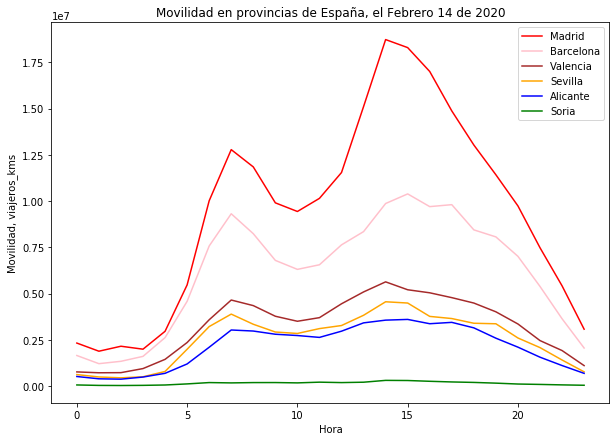

In [23]:
plt.figure(figsize=(10,7))

plt.plot(df['hora'], df[28], color='red', label='Madrid')
plt.plot(df['hora'], df[8], color='pink', label='Barcelona')
plt.plot(df['hora'], df[46], color='brown', label='Valencia')
plt.plot(df['hora'], df[41], color='orange', label='Sevilla')
plt.plot(df['hora'], df[3], color='blue', label='Alicante')
plt.plot(df['hora'], df[42], color='green', label='Soria')
plt.xlabel('Hora')
plt.ylabel('Movilidad, viajeros_kms')
plt.title('Movilidad en provincias de España, el Febrero 14 de 2020')
plt.legend()